# Lab Assignment 5

**Submission deadline:**
* **lab session in the week 8-12.1.24**

**Points: 1+3 points**


In [1]:
# Standard IPython notebook imports
%matplotlib inline

import os

import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import scipy.stats as sstats

import seaborn as sns
from sklearn import datasets

# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments'):
     from common.plotting import plot_mat

sns.set_style('whitegrid')

# MNIST

In [2]:
import matplotlib.pyplot as plt

def plot_digit(x_flat):
    fig = plt.figure(figsize = (2,2))
    plt.imshow(x_flat.reshape(28,28), cmap='gray')
    plt.show()


In [3]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

Downloading...
From: https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU
To: /content/mnist.npz
100% 55.4M/55.4M [00:01<00:00, 33.2MB/s]


In [4]:
with np.load('mnist.npz') as data:
    mnist_full_train_data_uint8 = data['train_data']
    mnist_full_train_labels_int64 = data['train_labels']
    mnist_test_data_uint8 = data['test_data']
    mnist_test_labels_int64 = data['test_labels']

# Split train data into train and validation sets
X_trn = mnist_full_train_data_uint8[:50000]
y_trn = mnist_full_train_labels_int64[:50000]
X_tst = mnist_full_train_data_uint8[50000:]
y_tst = mnist_full_train_labels_int64[50000:]

In [5]:
X_trn = X_trn.reshape(-1,28*28)
X_tst = X_tst.reshape(-1,28*28)

In [6]:
y_trn

array([5, 0, 4, ..., 8, 4, 8])

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [8]:
clf = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)

In [9]:
clf.fit(X_trn, y_trn)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

In [10]:
(clf.predict(X_trn) == y_trn).mean()

0.9734

In [11]:
(clf.predict(X_tst) == y_tst).mean()

0.9701

The above results are just basic accuracy stats of kNN on MNIST. Let's see below how they will change if we will reduce the dimensionality via PCA

## PCA

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=10)
pca.fit(X_trn)

PCA(n_components=10)

Top 10 components of PCA actually catch 48.9% of total variance of all the initial $28*28=784$ MNIST columns:

In [14]:
print(pca.explained_variance_ratio_.cumsum().round(3))

[0.097 0.168 0.23  0.284 0.333 0.376 0.409 0.437 0.465 0.489]


Let's see how a classifier performs that uses only these 10 columns:

In [15]:
X_trn_pca = pca.transform(X_trn)
X_trn_pca.shape

(50000, 10)

In [16]:
X_tst_pca = pca.transform(X_tst)
X_tst_pca.shape

(10000, 10)

In [17]:
clf_pca = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)

In [18]:
clf_pca.fit(X_trn_pca, y_trn)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

In [19]:
(clf_pca.predict(X_trn_pca) == y_trn).mean()

0.94226

In [20]:
(clf_pca.predict(X_tst_pca) == y_tst).mean()

0.9362

The accuracy is lil bit worse, but it's still quite impressive if you realize that now we operate only on 10 columns while the original MNIST has 784 columns. An intuitive explanation for why kNN can perform well after reducing to 10 main components can be seen below where we reduce to 2 dimensions. kNN on 2-dimensions has accuracy 53% and 44% on train and test set, which is way worse, but still very nontrivial.

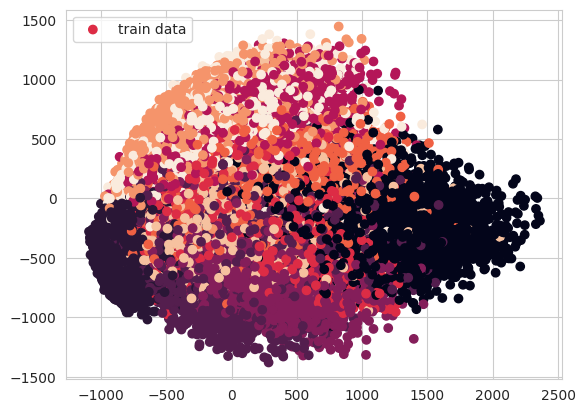

In [21]:
plt.scatter(X_trn_pca[:,0], X_trn_pca[:,1],   c=y_trn, label="train data")
plt.legend(loc="upper left")

In [22]:
X_inv_trn_pca = pca.inverse_transform(pca.transform(X_trn))

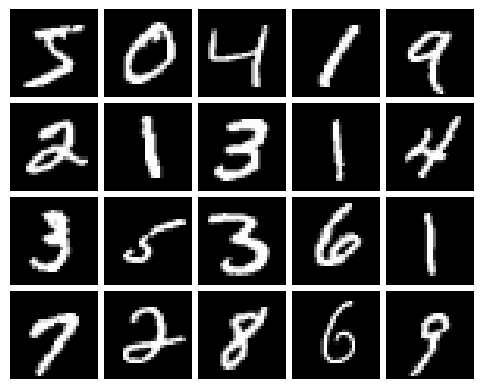

In [23]:
plot_mat(X_trn.reshape(-1,28,28)[:20, None], cmap='gray')

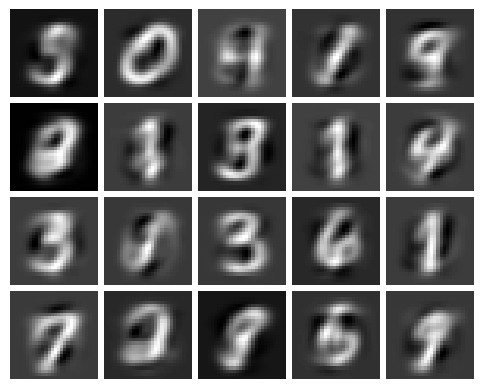

In [24]:
plot_mat(X_inv_trn_pca.reshape(-1,28,28)[:20, None], cmap='gray')

# Problem 1 [1p]

Find the smallest number of PCA components for which exists `k` such that k-Nearest Neighbors give accuracy on the test set at least 88%.

In [25]:
#your solution here

In [46]:
c=6
X = []

for n in range (1,100):
    pca = PCA(n_components=c)
    pca.fit(X_trn)

    X_trn_pca = pca.transform(X_trn)
    X_trn_pca.shape

    X_tst_pca = pca.transform(X_tst)
    X_tst_pca.shape

    clf_pca = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
    clf_pca.fit(X_trn_pca, y_trn)

    X.append((clf_pca.predict(X_tst_pca) == y_tst).mean())

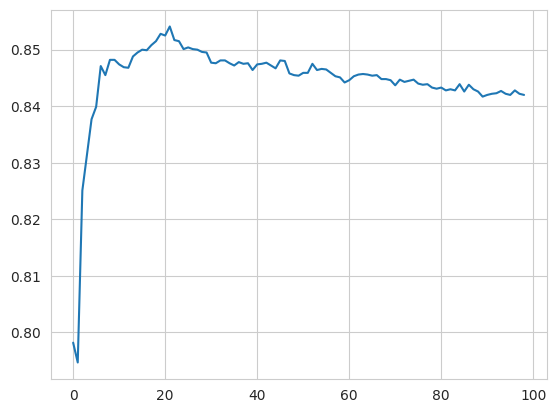

In [47]:
import  matplotlib.pyplot as plt

plt.plot(X)

In [45]:
c = 7

pca = PCA(n_components=c)
pca.fit(X_trn)

X_trn_pca = pca.transform(X_trn)
X_trn_pca.shape

X_tst_pca = pca.transform(X_tst)
X_tst_pca.shape

clf_pca = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
clf_pca.fit(X_trn_pca, y_trn)

(clf_pca.predict(X_tst_pca) == y_tst).mean()

0.8813

# Variance invariant

Let's take the original MNIST, and let's calculate the variance of each column:

In [27]:
np.var(X_trn,axis=0).shape

(784,)

and after that let's sum all of these variances.

In [28]:
np.var(X_trn, axis=0).sum()

3435520.706161413

Now let's do the same with PCA transformed MNIST.

In [29]:
pca = PCA()
pca.fit(X_trn)

PCA()

In [30]:
X_trn_pca = pca.transform(X_trn)

In [31]:
np.var(X_trn_pca, axis=0).sum()

3435520.706161437

Up to rounding errors, the values are the same. And that's not a coincidence.

## Problem 2 [3p]

Consider any dataset $X \in \mathbb{R}_n^d$, where $d$ is the number of columns, and $n$ is the number of samples. Let $\sum_{i=1}^d \mathcal{D}^2 X^i$ be the sum of variances of all the columns. Let $X_{pca} \in \mathbb{R}_n^d$ be the PCA transformed $X$ dataset. Show that $\sum_{i=1}^d \mathcal{D}^2 X^i = \sum_{i=1}^d \mathcal{D}^2 X_{pca}^i$.

Write the proof of this fact below. You can either do it in LaTeX, or you can write it in a reasonably elegant way on a piece of paper and paste an image here.

<div align="center">

\begin{align} \sum_{i=1}^d \mathcal{D}^2 X^i = \sum_{i=1}^d \mathcal{D}^2 X_{pca}^i \iff tr(Cov(X,X))=tr(Cov(X_{pca},X_{pca}))
\end{align}

Skorzystamy z faktu z algerby $tr(AB)=tr(BA)$ oraz faktu z wykładu $V_{k} V_{k}^{T} = I$


\begin{align}
tr(Cov(X_{pca},X_{pca})) &= tr(Cov(XV_{k},XV_{k})) = tr(\frac{1}{n-1}V_{k}^{T} X^{T} X V_{k}) \\
&= \frac{1}{n-1} tr(X^{T} X V_{k} V_{k}^{T}) = \frac{1}{n-1} tr(X^{T} X) = tr(Cov(X,X))
\end{align}

</div>